In [1]:
import matplotlib.pyplot as plt
import cv2
from semseg import get_mask
import numpy as np
import os

In [2]:
def get_vec(img, mask):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    vec = img_hsv[mask == 1].reshape(-1, 3) / 255
    return vec
    
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))

In [13]:
from tqdm import tqdm
dataset_dir = '/Users/sdale/repos/find_my_tie/dataset_v0'

bad_indices = []

print('getting paths...')
paths = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if '.jpg' in f]
print(len(paths))

print('getting images...')
imgs = [cv2.imread(path) for path in paths]

print('getting masks...')
masks = []
for i, img in tqdm(enumerate(imgs)):
    try:
        mask = get_mask(img)
    except:
        bad_indices.append(i)
        continue
    masks.append(mask)

new_imgs = []
new_paths = []
for i in range(len(imgs)):
    if i not in bad_indices:
        new_imgs.append(imgs[i])
        new_paths.append(paths[i])
imgs = new_imgs
paths = new_paths

print('getting vecs...')
vecs = [get_vec(img, mask) for img, mask in zip(imgs, masks)]

BINS = 50
print('calculating hue hists...')
hue_hists = [
    np.histogram(vec[:, 0], bins=BINS, range=[0, 1], density=True)[0]
    for vec in vecs
]
print('calculating saturation hists...')
sat_hists = [
    np.histogram(vec[:, 1], bins=BINS, range=[0, 1], density=True)[0]
    for vec in vecs
]
print('calculating value hists...')
val_hists = [
    np.histogram(vec[:, 2], bins=BINS, range=[0, 1], density=True)[0]
    for vec in vecs
]    

getting paths...
461
getting images...
getting masks...


461it [00:03, 140.81it/s]


getting vecs...
calculating hue hists...
calculating saturation hists...
calculating value hists...


In [8]:
len(hue_hists)

458

In [24]:
target_i = 3

target_hue_hist = hue_hists[target_i]
target_sat_hist = sat_hists[target_i]
target_val_hist = val_hists[target_i]

HW, SW, VW = 5, 3, 1

hue_scores = np.array([HW * histogram_intersection(target_hue_hist, hue_hist) for hue_hist in hue_hists])
sat_scores = np.array([SW * histogram_intersection(target_sat_hist, sat_hist) for sat_hist in sat_hists])
val_scores = np.array([VW * histogram_intersection(target_val_hist, val_hist) for val_hist in val_hists])

scores = HW * hue_scores + SW * sat_scores + VW * val_scores

# in descending order
sorted_i = np.argsort(-np.array(scores))

In [26]:
scores.shape

(458,)

In [27]:
len(hue_scores)

458

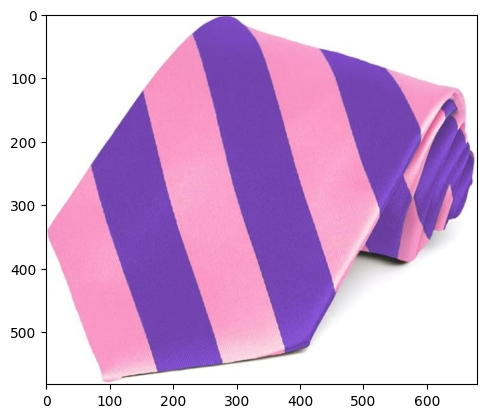

In [28]:
plt.imshow(plt.imread(paths[target_i]))

784.184644728436


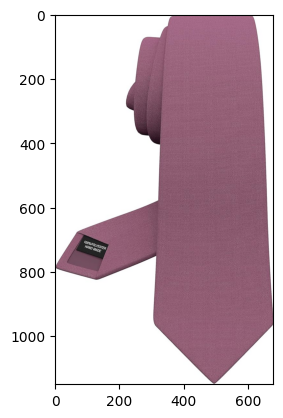

In [38]:
other_i = 8
print(scores[sorted_i[other_i]])
plt.imshow(plt.imread(paths[sorted_i[other_i]]))

In [ ]:
plt.imshow(masks)

In [ ]:
plt.hist(vecs[target_i][:, 0], bins=BINS, range=[0, 1], density=True, alpha=0.5)
plt.hist(vecs[other_i][:, 0], bins=BINS, range=[0, 1], density=True, alpha=0.5)